In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings

pd.options.display.float_format = '{:.2f}'.format

from model_SARIMA import *
from model_naiv import build_naive_model
from test_mean import t_test, wilcoxon_test, binomial_test, kolmogorov_test
from test_correlation import *
from test_normal import hist_plot
from time_series import *
from cross_validation import *


warnings.filterwarnings("ignore")

/Users/alex/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Datensatz lesen

In [2]:
df = pd.read_csv('Walmart_Sales.csv', parse_dates=['Date'], dayfirst=True)
df.columns = df.columns.str.lower()

1 Store wählen

In [3]:
# Filtern nach Store
store_number = 33
store = df[df['store'] == store_number].copy()

# Datum als Index setzen
store.set_index('date', inplace=True)

# Spalte Weekly_Sales extrahieren
sales = store['weekly_sales']
sales = sales.asfreq('W-FRI')

Zeitreihe plotten

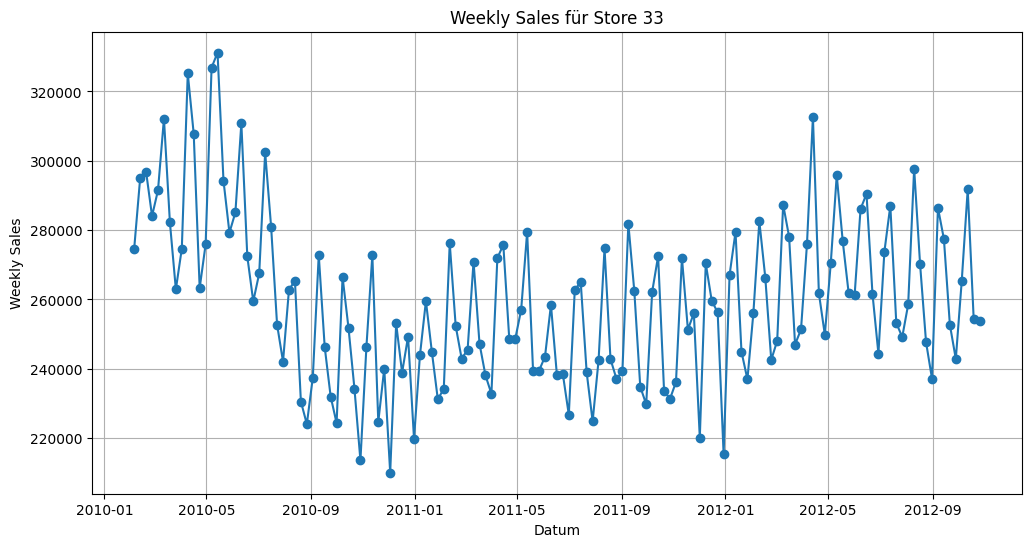

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(sales, marker='o', linestyle='-')
plt.title('Weekly Sales für Store {}'.format(store_number))
plt.xlabel('Datum')
plt.ylabel('Weekly Sales')
plt.grid(True)
plt.show()

Seasonal

In [5]:
#seasonal_plot(sales)
#seasonal_subseries_plot(sales)
#acf_plot(sales)
#lag_plot(sales)
#decompose(sales)

SARIMA Modell

In [6]:
sarima_params  = optimal_orders_notstepwise.get(str(store_number))

order = tuple(sarima_params["order"])
seasonal_order = tuple(sarima_params["seasonal_order"])

sarima_model = build_SARIMA(sales, order = order, seasonal_order = seasonal_order)
sarima_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                        weekly_sales   No. Observations:                  143
Model:             SARIMAX(0, 1, 4)x(1, 0, [], 52)   Log Likelihood               -1608.056
Date:                             Tue, 15 Apr 2025   AIC                           3228.113
Time:                                     16:15:07   BIC                           3245.848
Sample:                                 02-05-2010   HQIC                          3235.320
                                      - 10-26-2012                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1133      0.054     -2.106      0.035      -0.219      -0.008
ma.L2         -0.1276      0.041     -3.126      0.002      -0.208      -0.048
ma.L3         -0.1917      0.051     -3.753      0.000      -0.292      -0.092
ma.L4          0.2718      0.054      5.080      0.000       0.167       0.377
ar.S.L52       0.2209      0.039      5.620      0.000       0.144       0.298
sigma2      5.179e+08   1.43e-11   3.62e+19      0.000    5.18e+08    5.18e+08
===================================================================================
Ljung-Box (L1) (Q):                   3.11   Jarque-Bera (JB):                 0.31
Prob(Q):                              0.08   Prob(JB):                         0.86
Heteroskedasticity (H):               0.51   Skew:                             0.07
Prob(H) (two-sided):                  0.02   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.35e+33. Standard errors may be unstable.
"""

Naives Modell

In [7]:
naiv_resid, naiv_fitted = build_naive_model(sales)

Modell wählen

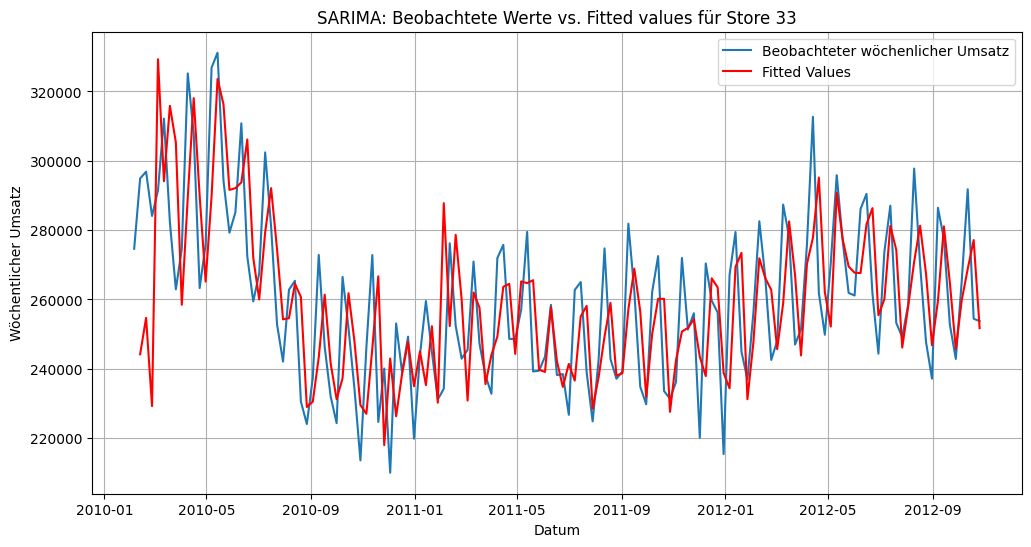

In [8]:
#residuen = naiv_resid
#fitted_values = naiv_fitted

resid = sarima_model.resid.iloc[1:]
fitted_values = sarima_model.fittedvalues.iloc[1:]

relative_resid = resid / sales.iloc[1:]

plt.figure(figsize=(12, 6))
plt.plot(sales, label='Beobachteter wöchenlicher Umsatz')
plt.plot(fitted_values, color='red', label='Fitted Values')
plt.title('SARIMA: Beobachtete Werte vs. Fitted values für Store {}'.format(store_number))
plt.xlabel('Datum')
plt.ylabel('Wöchentlicher Umsatz')
plt.legend()
plt.grid(True)
plt.show()

Korrelation Tests

Box Pierce Test
p-Wert an lag 29: 0.0000
p-Wert Median: 6.445199876224892e-21
1     NaN
2     NaN
3     NaN
4     NaN
5     NaN
6     NaN
7     NaN
8     NaN
9    0.00
10   0.00
11   0.00
12   0.00
13   0.00
14   0.00
15   0.00
16   0.00
17   0.00
18   0.00
19   0.00
20   0.00
21   0.00
22   0.00
23   0.00
24   0.00
25   0.00
26   0.00
27   0.00
28   0.00
29   0.00
Name: bp_pvalue, dtype: float64

Ljung Box Test
p-Wert an lag 29: 0.0000
p-Wert Median: 4.0074442889054445e-23

Breusch Godfrey: 0.2348
Monti Test: 0.0000
Fisher Test: 0.0000
Run Test: 0.1289
Durbin Watson: 2.2263


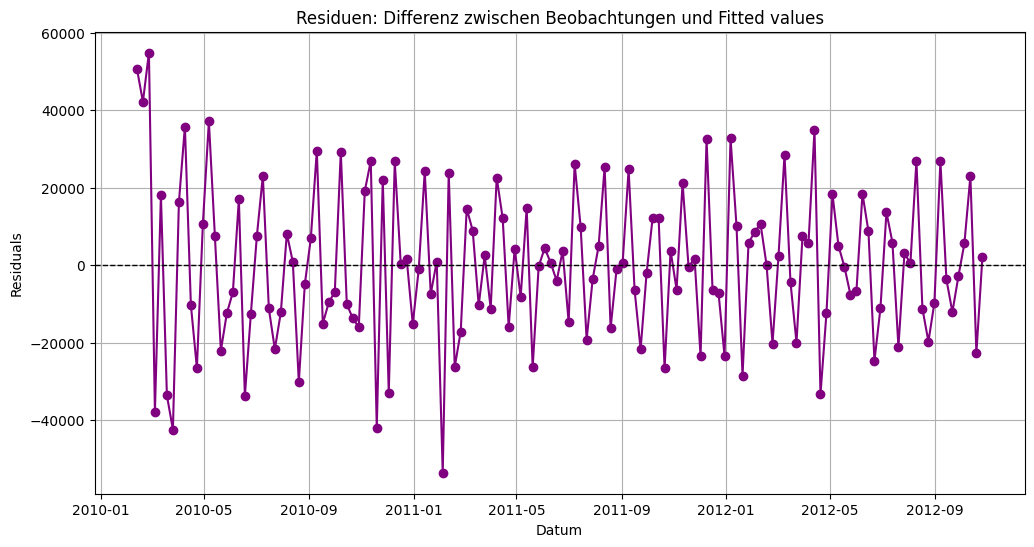

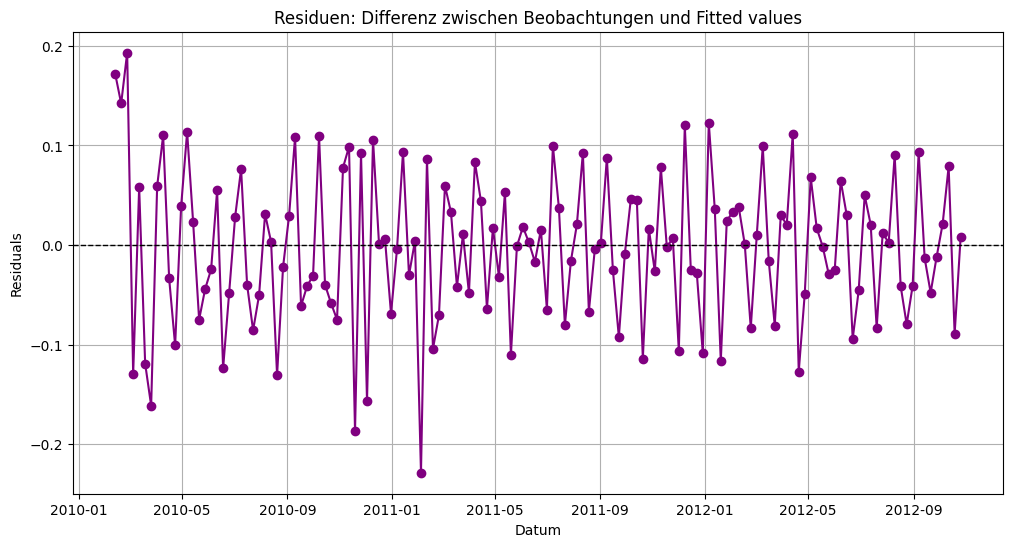

<Figure size 1200x600 with 0 Axes>

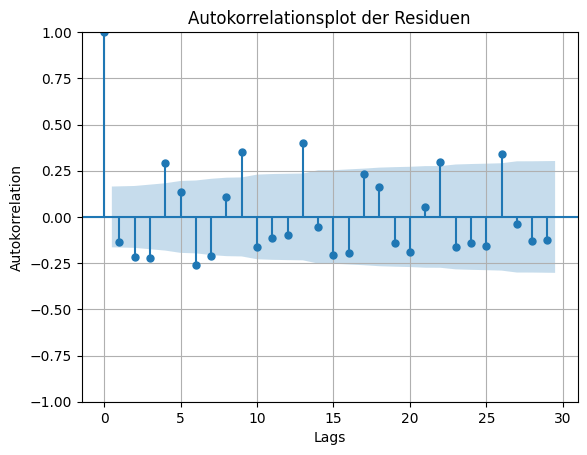

In [9]:
box_pierce_test(residuals = resid, store_num = store_number, lags = 29)
ljung_box_test(residuals = resid, store_num = store_number, lags = 29)
breusch_godfrey_test(model = sarima_model, lags = 29)
monti_test(residuals = resid, store_num = store_number, m = 29)
fisher_test(residuals = resid, store_num = store_number, m = 4)
run_test(residuals = resid)

durbin_watson_test(residuals = resid)

residual_plot(resid)
residual_plot(relative_resid)

acf_resid_plot(resid, lags = 29)


Mittelwert Tests

Mittelwert der Residuen: -12.7020
Mittelwert der relativen Residuen: -0.0036
T-Test: 0.9939
Wilcoxon Test: 0.8971
Binomial Test: 0.9332
Kolmogorov Test: 0.9799


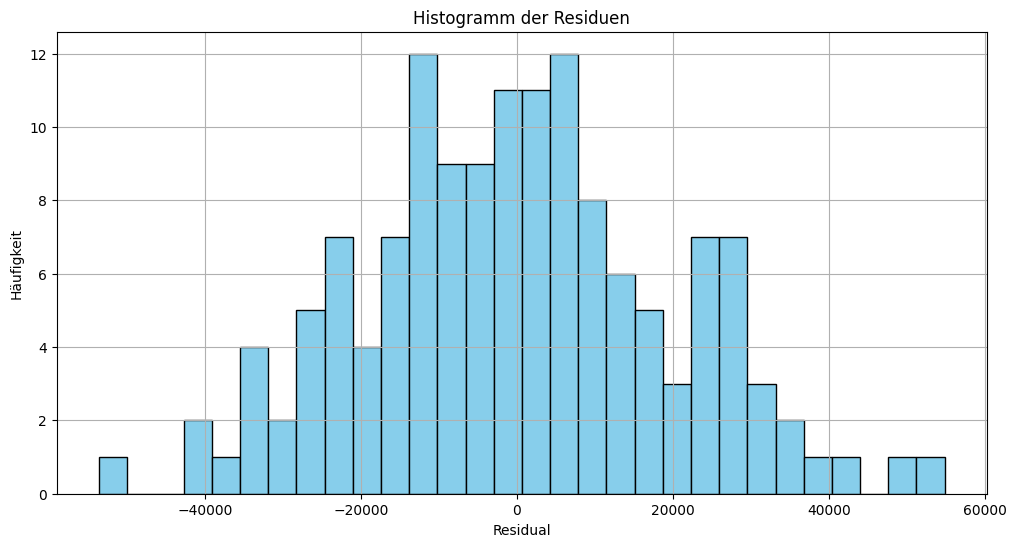

In [10]:
print(f"Mittelwert der Residuen: {resid.mean():.4f}")
print(f"Mittelwert der relativen Residuen: {relative_resid.mean():.4f}")


t_test(resid)
wilcoxon_test(resid)
binomial_test(resid)
kolmogorov_test(resid)

hist_plot(resid)


SMAPE

In [11]:
numerator = np.abs(fitted_values - sales.iloc[1:])
denominator = (np.abs(fitted_values) + np.abs(sales.iloc[1:])) / 2
smape = np.where(denominator == 0, 0, numerator / denominator)
smape = np.mean(smape) * 100
print(f"SMAPE: {smape:.2f}%")

SMAPE: 5.97%


Kreuz Validierung

In [12]:
cv_df, train_size = cross_validation_SARIMA(sales, order = order, seasonal_order = seasonal_order)
#cv_df = cross_validation_naive(sales)


KeyboardInterrupt: 

Korrelations Tests

Box Pierce Test
p-Wert an lag 29: 0.0205
p-Wert Median: 0.002918178288381011
1     NaN
2     NaN
3     NaN
4     NaN
5     NaN
6     NaN
7     NaN
8     NaN
9    0.00
10   0.00
11   0.00
12   0.00
13   0.00
14   0.00
15   0.00
16   0.00
17   0.00
18   0.00
19   0.00
20   0.00
21   0.01
22   0.01
23   0.02
24   0.02
25   0.02
26   0.01
27   0.01
28   0.02
29   0.02
Name: bp_pvalue, dtype: float64

Ljung Box Test
p-Wert an lag 29: 0.0000
p-Wert Median: 4.401226245986433e-05

Breusch Godfrey: 0.9992
Monti Test: 0.0000
Fisher Test: 0.0000
Run Test: 0.2153
Durbin Watson: 2.5215


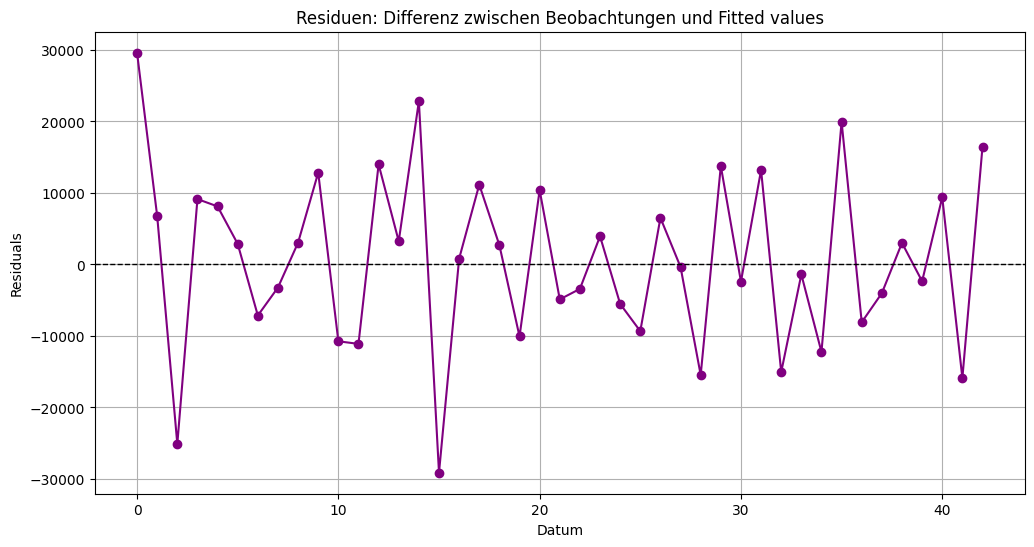

<Figure size 1200x600 with 0 Axes>

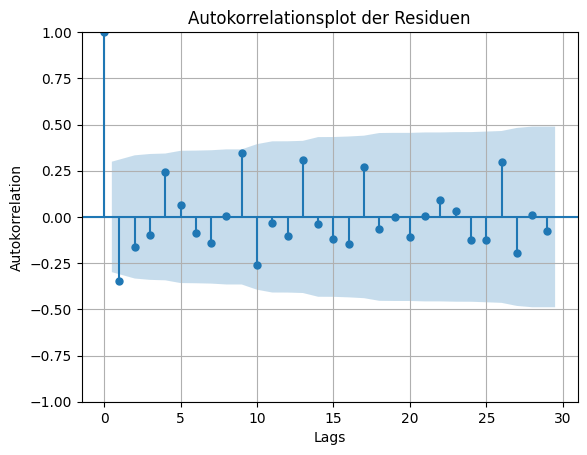

In [ ]:
errors = cv_df['error']

box_pierce_test(residuals = errors, store_num = store_number, lags = 29)
ljung_box_test(residuals = errors, store_num = store_number, lags = 29)
breusch_godfrey_test(model = sarima_model, lags = 29) #TODO: gleiches modell wie in-sample?
monti_test(residuals = errors, store_num = store_number, m = 21)
fisher_test(residuals = errors, store_num = store_number, m = 4)
run_test(residuals = errors)

durbin_watson_test(residuals = errors)

residual_plot(residuals = errors)
acf_resid_plot(residuals = errors)


Mittelwert Tests

Mittelwert der Errors: 626.1077806880131
T-Test: 0.7409
Wilcoxon Test: 0.7243
Binomial Test: 1.0000
Kolmogorov Test: 0.9986


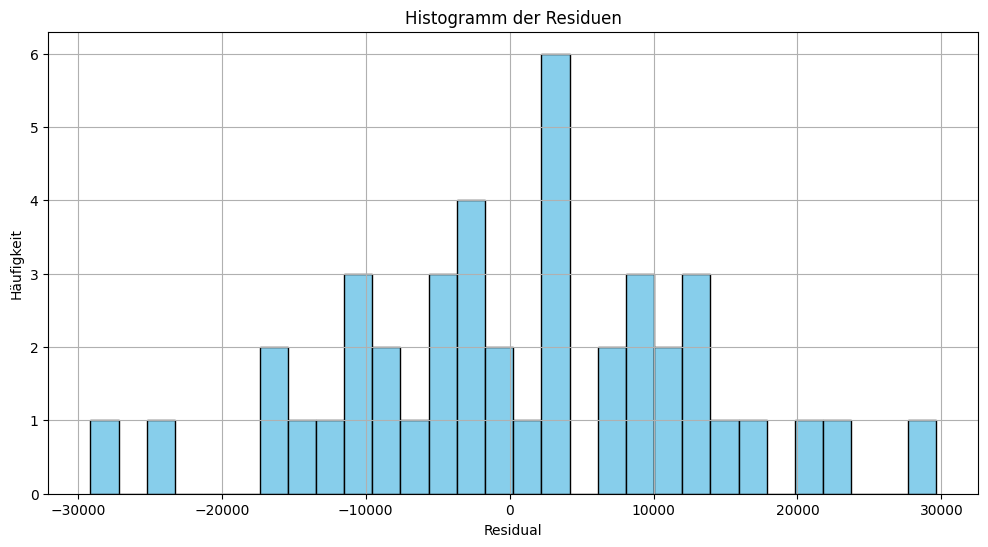

In [ ]:
#mean_errors = errors.mean()
print(f'Mittelwert der Errors: {errors.mean()}')

t_test(errors)
wilcoxon_test(errors)
binomial_test(errors)
kolmogorov_test(errors)

hist_plot(errors)


SMAPE

In [ ]:
actual_values = cv_df['actual']
forecast_values = cv_df['forecast']

numerator = np.abs(forecast_values - actual_values)
denominator = (np.abs(forecast_values) + np.abs(actual_values)) / 2
smape = np.where(denominator == 0, 0, numerator / denominator)
smape = np.mean(smape) * 100
print(f"SMAPE: {smape:.2f}%")

SMAPE: 3.70%
